In [16]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
from empmap.collate_map import EmpiricalMap
from empmap.poly_fit import mu_fit_selector
from empmap.potential import Potential1D
from empmap.sincdvr import DVR
from empmap.constants import ConstantsManagement

In [17]:
from matplotlib import rcParams
from cycler import cycler

rcParams['figure.titlesize']=16
rcParams['font.size']=12
rcParams['axes.titlesize']=16
rcParams['axes.labelsize']=24
rcParams['figure.labelsize']=28
rcParams['xtick.labelsize']=16
rcParams['ytick.labelsize']=16
rcParams['axes.linewidth'] = 1.5
rcParams['lines.markersize']=4
rcParams['lines.linewidth']=2.5
rcParams['xtick.major.size'] = 5
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 5
rcParams['ytick.major.width'] = 1
rcParams['xtick.bottom'] = True
rcParams['xtick.top']=True
rcParams['xtick.direction']="in"
rcParams['ytick.left'] = True
rcParams['ytick.right'] = True
rcParams['ytick.direction']="in"
rcParams['svg.fonttype'] = 'none'

In [18]:
new_map = EmpiricalMap.load_self("example_maps/doh_d2o_gas.pckl")
new_map.fit_full_empirical_map(order_omega=2, order_x=1, order_mu=1, sigma_pos=[-1])
print("******* Fit R^2 Values ********")
for key in new_map.map_fit_parameters.keys():
    print(f"{key:} {new_map.map_fit_parameters[key][2]:10.5f}")

experimental_w01 = 3707
print(new_map.w01[-1], new_map.w01[0]/experimental_w01)
scale_factor = new_map.w01[0]/experimental_w01


w01 = 3720.1847933917 + -3622.5526895387*Eproj + -83153.2049434688*Eproj^2
w12 = 3563.2717522744 + -4141.9649369350*Eproj + -104090.0431870354*Eproj^2
x01 = 0.1939422968 + -0.0000174945*w01
x12 = 0.2699338126 + -0.0000241701*w12
dmu_num = 0.2395298256 + 22.4636816454*Eproj
dmu = 0.0357054841 + 18.8150937801*Eproj
dmu_num_scaled = 1.1815457162 + 89.4891788369*E
******* Fit R^2 Values ********
w01    0.76646
w12    0.77358
x01    0.99851
x12    0.99810
dmu_num    0.82497
dmu    0.14384
dmu_num_scaled    0.82734
3713.5190185518395 0.9282857690370445


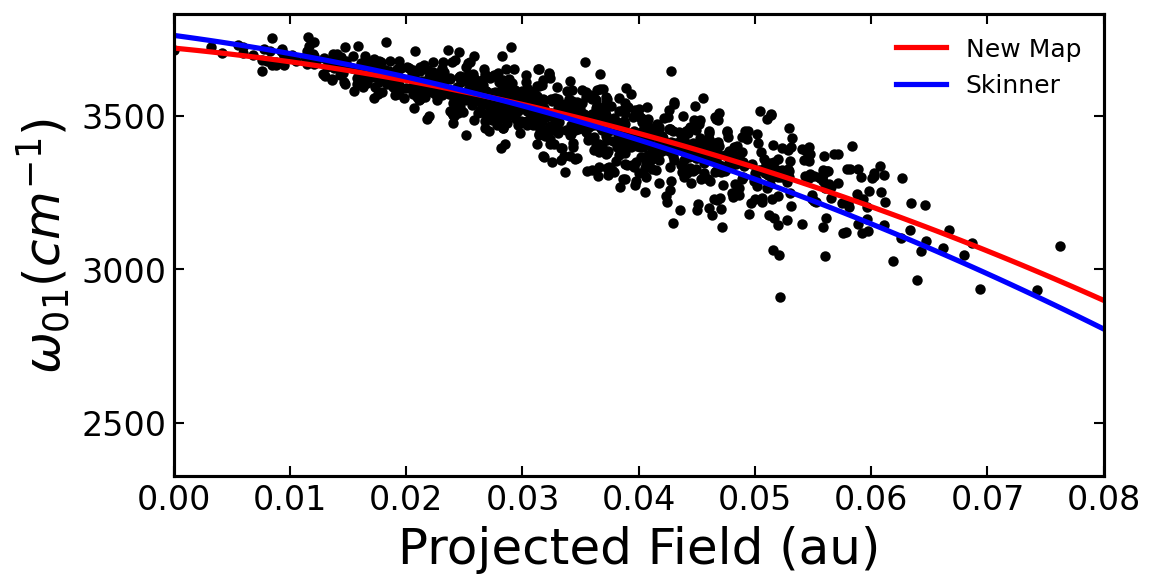

In [19]:
popt, pcov, r2 = new_map.map_fit_parameters['w01']
poly = mu_fit_selector(2)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3761.6, -5060.4, -86225)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, new_map.w01, c='black')
plt.plot(evals, yvalues, c='red', label='New Map')
plt.plot(evals, skinner, c='blue', label='Skinner')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{01} (cm^{-1})$")
plt.legend(frameon=False)
plt.xlim(0, 0.08)
plt.show()

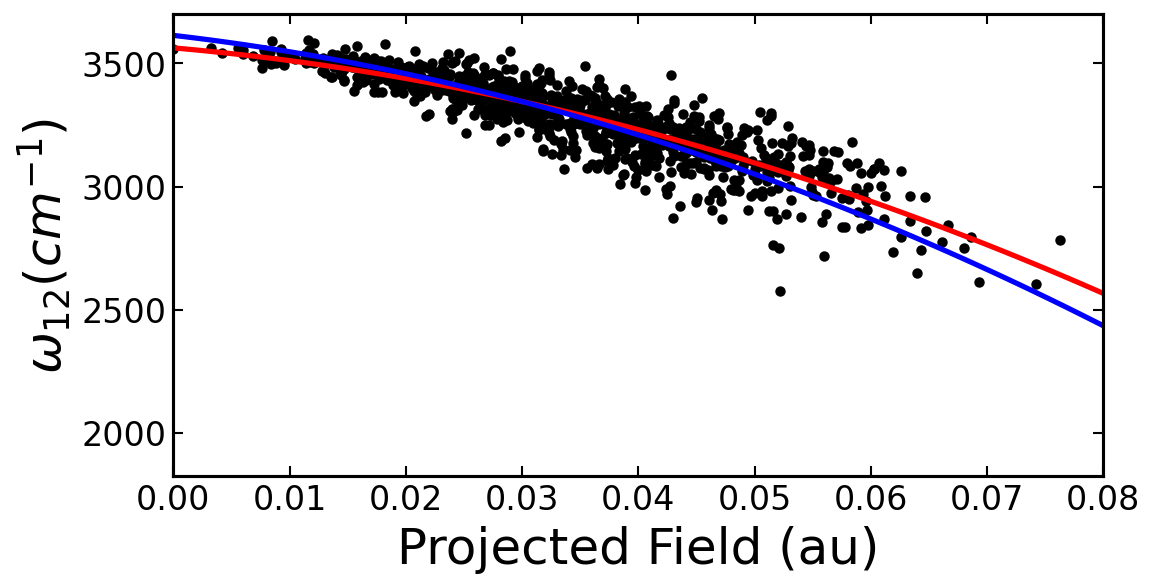

In [20]:
popt, pcov, r2 = new_map.map_fit_parameters['w12']
poly = mu_fit_selector(2)
evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)
skinner = poly(evals, 3614.1, -5493.7, -115670)
fig = plt.figure(figsize=(8,4), dpi=150)
plt.scatter(new_map.Eproj, new_map.w12, c='black')
plt.plot(evals, yvalues, c='red')
plt.plot(evals, skinner, c='blue')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\omega_{12} (cm^{-1})$")
plt.xlim(0, 0.08)
plt.show()

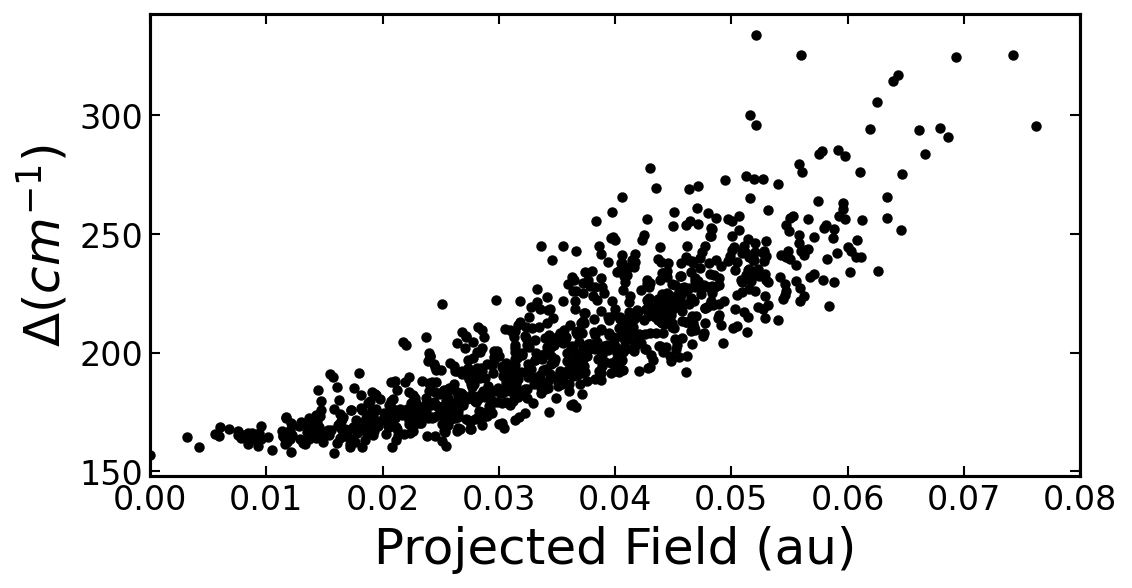

In [21]:
fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, np.array(new_map.w01)-np.array(new_map.w12), c='black')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\Delta (cm^{-1})$")
plt.xlim(0, 0.08)
plt.show()

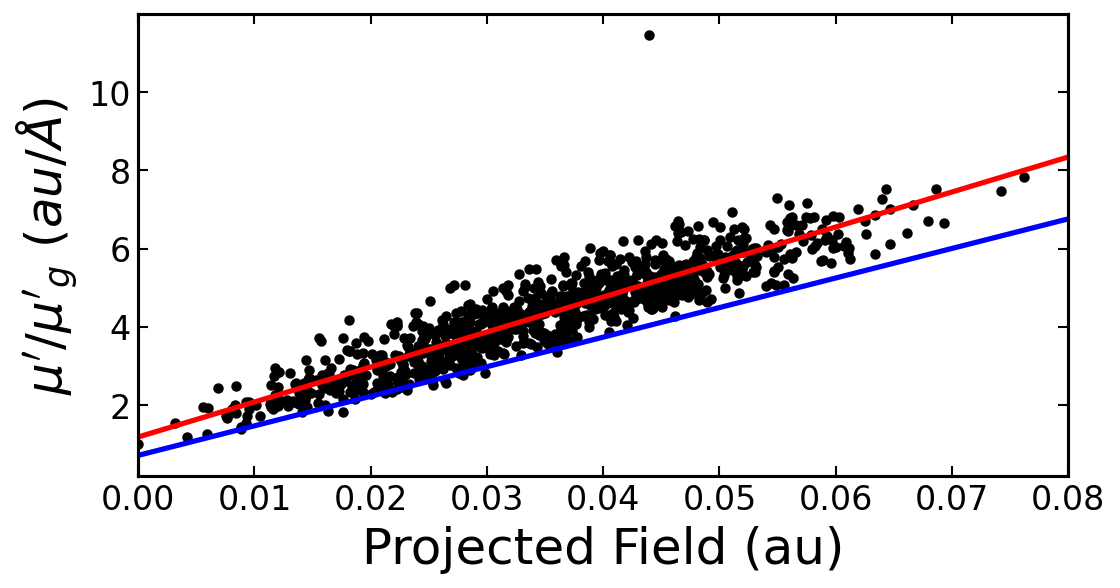

In [37]:
popt, pcov, r2 = new_map.map_fit_parameters['dmu_num_scaled']
poly = mu_fit_selector(1)

evals = np.linspace(0.0, 0.10, 100)
yvalues = poly(evals, *popt)

skinner = poly(evals, 0.71116, 75.591)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.Eproj, new_map.dmu_num/new_map.dmu_num[-1], c='black')
plt.plot(evals, skinner, c='blue')
plt.plot(evals, yvalues, c='red')
plt.xlabel("Projected Field (au)")
plt.ylabel("$\mu'/\mu'_g~(au/\AA)$")
plt.xlim(0, 0.08)
plt.show()

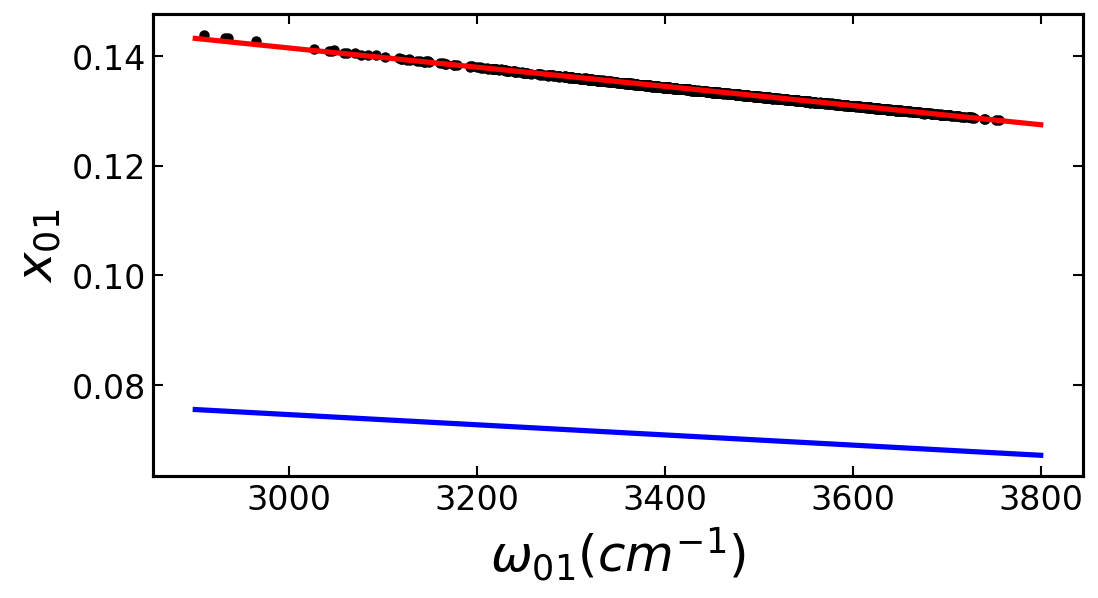

In [38]:
popt, pcov, r2 = new_map.map_fit_parameters['x01']
poly = mu_fit_selector(1)

evals = np.linspace(2900, 3800, 1000)
yvalues = poly(evals, *popt)
skinner = poly(evals, 0.1024, -0.927E-5)

fig = plt.figure(figsize=(8,4),dpi=150)
plt.scatter(new_map.w01, new_map.x01, c='black')
plt.plot(evals, yvalues, c='red')
plt.plot(evals, skinner, c='blue')
plt.xlabel("$\omega_{01} (cm^{-1})$")
plt.ylabel("$x_{01}$")
plt.show()

## Build a Potential for a Gas Phase Molecule

In [24]:
pot1d = Potential1D("example_potential/scan_rOHs.dat", "example_potential/scan_energies.dat", "example_potential/scan_dipoles.dat", "example_potential/scan_eOHs.dat")
pot1d.fit_potential_to_poly(8)
pot1d.fit_dipole_to_poly(3)

dvr = DVR(pot1d, emax=10.0, xmax=2.1, mass1=2.0014, mass2=15.999)
dvr.do_calculation()

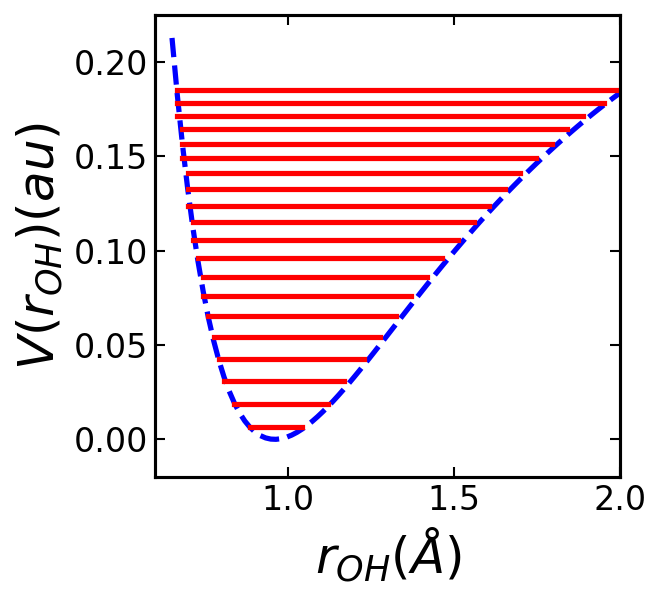

In [25]:
fig = plt.figure(figsize=(4,4),dpi=150)
display=True
xvals = np.linspace(0.65, 2.2, 100)

constants = ConstantsManagement()
plt.plot(xvals, dvr.pot1d.pot_fit['poly'](xvals, *dvr.pot1d.pot_fit['popt']), c='blue', ls = '--')
#plt.scatter(dvr.pot1d.rOH, dvr.pot1d.pot_energy, c='black', s=20)
#plt.scatter(dvr.xgrid*constants.angperau, dvr.pot1d.pot_fit['poly'](dvr.xgrid*constants.angperau, *dvr.pot1d.pot_fit['popt']), c='red')
if display:
    for eval in dvr.evals[:20]:
        # find the two intersectiosn between dvr.pot1d.pot_fit['poly'](xvals, *dvr.pot1d.pot_fit['popt']) and the eval
        lower = np.argmin(np.abs(dvr.pot1d.pot_fit['poly'](xvals[xvals<1.0], *dvr.pot1d.pot_fit['popt']) - eval))
        upper = np.argmin(np.abs(dvr.pot1d.pot_fit['poly'](xvals[xvals>1.0], *dvr.pot1d.pot_fit['popt']) - eval)) + len(xvals[xvals<1.0])
        plt.plot(xvals[lower:upper], [eval] * len(xvals[lower:upper]), c='red')
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$V(r_{OH}) (au)$")
plt.xlim(0.6,2)
plt.ylim(-0.02,0.225)
plt.show()


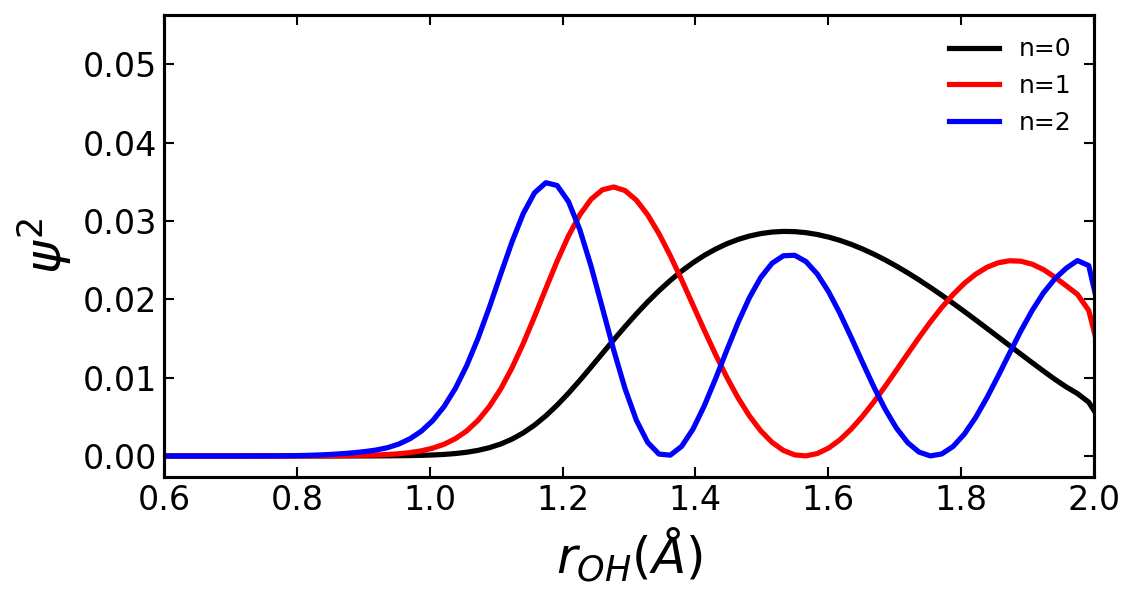

In [26]:
fig = plt.figure(figsize=(8,4),dpi=150)
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[0], dvr.evecs[0]), c='black', label='n=0')
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[1], dvr.evecs[1]), c='red', label='n=1')
plt.plot(dvr.xgrid*constants.angperau, np.multiply(dvr.evecs[2], dvr.evecs[2]), c='blue', label='n=2')
plt.xlim(0.6,2)
plt.legend(frameon=False)
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\psi^2$")
plt.show()

### The Dipole Moment Fitting

0.9590338519967926
r0 is 1.8017871689311085
imin is 55


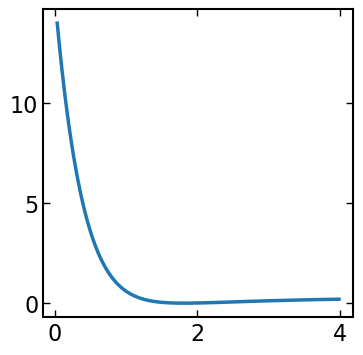

In [27]:
vraw = pot1d.pot_fit['poly'](
            dvr.xraw*constants.angperau, *dvr.pot1d.pot_fit['popt'])
print(pot1d.pot_fit['r0'])
r0_index = np.argmin(vraw)
r0 = dvr.xraw[r0_index]
print(f"r0 is {r0}")
drOH = np.abs(dvr.xraw - r0)
imin = np.argmin(drOH)
print(f"imin is {imin}")

fig = plt.figure(figsize=(4,4))
plt.plot(dvr.xraw, vraw)
plt.show()

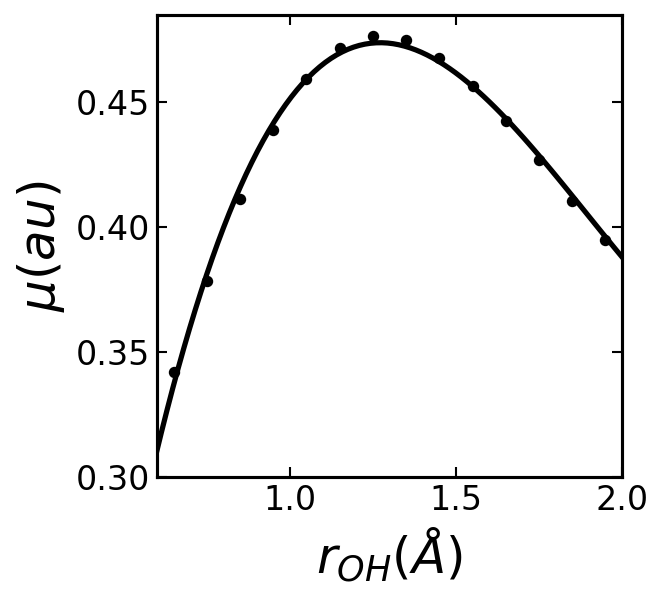

In [28]:
fig = plt.figure(figsize=(4,4),dpi=150)
mu_poly = pot1d.mu_fit['poly']
xdata = dvr.xgrid*constants.angperau
mu_data = mu_poly(xdata, *pot1d.mu_fit['popt'])
plt.plot(xdata, mu_data, c='black')
plt.scatter(pot1d.rOH, pot1d.mu, c='black', s=20)

plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\mu (au)$")
plt.xlim(0.6,2)
plt.show()

In [31]:
def numerical_derivative(x, y):
    return np.gradient(y, x)

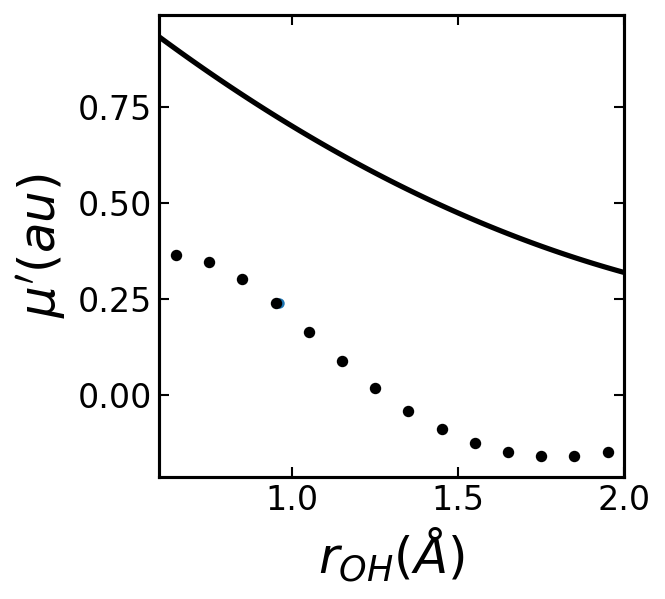

In [36]:
fig = plt.figure(figsize=(4,4),dpi=150)
dmu_poly = pot1d.mu_fit['mu_deriv_poly']
xdata = dvr.xgrid*constants.angperau
dmu_data = dmu_poly(xdata, *pot1d.mu_fit['dmu_popt'])
plt.plot(xdata, dmu_data, c='black')
plt.scatter(pot1d.pot_fit["r0"], pot1d.mu_fit['dmu_num'])
plt.scatter(pot1d.rOH, numerical_derivative(pot1d.rOH, pot1d.mu), c='black', s=20)
plt.xlabel("$r_{OH} (\AA)$")
plt.ylabel("$\mu' (au)$")
plt.xlim(0.6,2)
plt.show()